# Resistance Logistic Regression Models Using Merged Data Experiment 1.1

In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-09-25 06:11:29 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-09-25 06:11:29 INFO: Downloading default packages for language: en (English) ...
2024-09-25 06:11:30 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-09-25 06:11:32 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-09-25 06:11:32 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-09-25 06:11:33 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-09-25 06:11:34 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-09-25 06:11:34 INFO: Using device: cpu
2024-09-25 06:11:34 INFO: Loading: tokenize
2024-09-25 06:11:34 INFO: Loading: mwt
2024-09-25 06:11:34 INFO: Loading: pos
2024-09-25 06:11:34 INFO: Loading: lemma
2024-09-25 06:11:34 INFO: Loading: constituency
2024-09-25 06:11:34 INFO: Loading: depparse
2024-09-25 06:11:35 INFO: Loading: sentiment
2024-09-25 06:11:35 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [2]:
merged_resistance_df = pd.read_csv("../../../../data/processed_for_model/merged_themes_using_jaccard_method/merged_Resistance_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_resistance_df = shuffle(merged_resistance_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_resistance_df, test_size=0.3, random_state=18, stratify=merged_resistance_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
training_df.head()

,sentence,label,phrase
0,"math always seems to give me a little bit of trouble, but i get a hang of it after pushing myself to do the best i can.",1,"['Math always seems to give me a little bit of trouble, but I get a hang of it after pushing myself to do the best I can.']"
1,"after working minimum wage part time jobs while in community college, i've learned that there is no way i can do that for the rest of my life.",0,"[""After working minimum wage part time jobs while in community college, i've learned that there is no way I can do that for the rest of my life. If I didn't chose to be here, I would honestly have no idea or guess to where I would be now but all the decision making and experiences i've had in my life has led me here""]"
2,"this would cause a sharp pain in my elbow whenever i would do pushups, bench press, or simply bending my arm would result in a cracking like noise.",0,"['When I went to physical therapy, my therapist and I got really close during my process of rehabilitation. After healing my elbow completely, my physical therapist taught me important tips on taking care of my body overall as well as continuing my dreams of playing basketball professionally. My overall goal as to why I am in college is to become a physical therapist.']"
3,i believe i am here to better my life.,0,"['I want to be able to say I went back and finished school, but not only finished, but completed a major that most never thought I would be able to do.']"
4,"i am here because i want to better myself my family, not only financially but in health.",0,"['I know that as a child I never thought of education and a career for someone who is undocumented.', 'I Hope to reach a position in which I can inspire and prove to all of the ""immigrants"" in the USA that achieving and surpassing struggle is possible.']"


In [4]:
test_df.head()

,sentence,label,phrase
0,"keeping an open mind i am looking forward to this transition and know it will be difficult but after the military nothing really can be that bad, or can it? expectations for this class are high i suppose in the fact that this course takes prerequisites to even get into.",0,"['I am a Disabled Veteran and am coming back to school to learn skills more properly suited for civilian interaction, basically here to learn something thats not related to killing and dealing with guns since all those skills do is help me stay in the cycle of protection lines of work (cop, security, etc...). Keeping an open mind I am looking forward to this transition and know it will be difficult but after the military nothing really can be that bad, or can it?']"
1,"i am here to prove that i can do anything i set my mind to, not only to others, but to myself as well.",1,"['I am here to prove that I can do anything I set my mind to, not only to others, but to myself as well.']"
2,being in physics is difficult for me because there are many formulas i need to memorize.,0,"[""Being in physics is difficult for me because there are many formulas I need to memorize. So another reason I'm in the lab is to form groups that will help me learn the terms and formulas better.""]"
3,physics why am i here?,0,"['Despite, all these concepts that is definitely interesting, I feel physics can be sometimes hard to be understood with all the details and mind boggling questions it includes. Yet, these concepts will be an important part of my work I will be doing in the future. Thus, I am here to learn physics and more to get better.']"
4,"i used to always be a quitter, and very early on in high school i decided that i was not smart enough to understand science but i have learned that dedication, passion, and hard work are key.",1,"['I used to always be a quitter, and very early on in high school I decided that I was not smart enough to understand science but I have learned that dedication, passion, and hard work are key.']"


In [5]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (842, 3) 
Test dataset shape: (362, 3)
Positive labels present in the dataset : 61  out of 842 or 7.244655581947744%
Positive labels present in the test dataset : 26  out of 362 or 7.18232044198895%


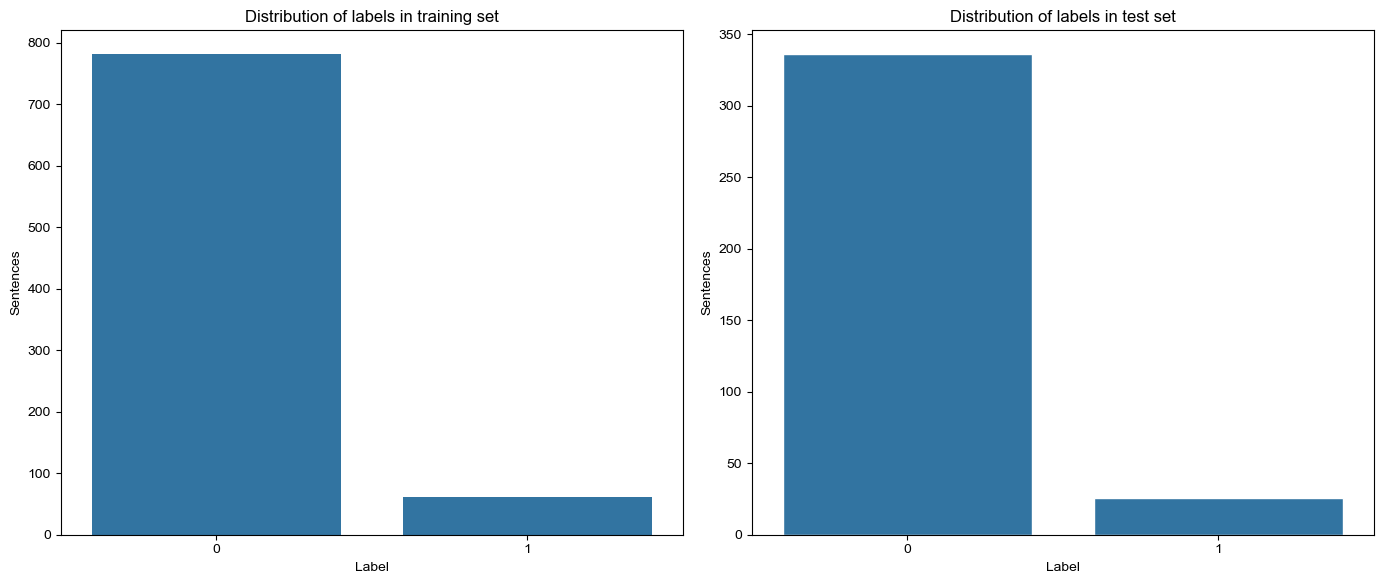

In [6]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [7]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [8]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [9]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [10]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [11]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['gynecology', 'heart', 'sports', 'transfusion', 'orbit', 'brain', 'hepatology', 'neonatal', 'neurology', 'abuse', 'perinatal', 'dermatopathology', 'urologic', 'toxicology', 'gastrointestinal', 'urology', 'pain', 'care', 'glaucoma', 'anesthesiology', 'cytogenetics', 'oncology', 'cardiovascular', 'surgery', 'anesthesiology', 'behavioral', 'interventional', 'neuro', 'pelvic', 'pediatrics', 'male', 'musculoskeletal', 'liaison', 'military', 'retina', 'psychiatry', 'sports', 'neurodevelopmental', 'nephrology', 'administrative', 'medicine', 'genetics', 'reconstructive', 'molecular', 'neuroradiology', 'psychiatry', 'cytopathology', 'immunopathology', 'emergency', 'nuclear', 'psychiatric', 'adolescent', 'neurourology', 'mental', 'medical', 'surgery', 'anterior', 'transplant', 'pediatrics', 'disease', 'neuromuscular', 'endocrinologists', 'occupational', 'microbiology', 'biochemical', 'infectious', 'calculi', 'reconstructive', 'blood', 'gynecologic', 'genitourinary', 'child', 'pulmonary', 'aller

In [12]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [13]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [14]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [15]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [16]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [17]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [19]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [20]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [21]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [22]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [23]:
X_train, y_train = feature_engineering(training_df)

In [24]:
X_train.shape

(842, 121)

In [25]:
y_train = y_train.astype('int')

In [26]:
X_test, y_test = feature_engineering(test_df)

In [27]:
X_test.shape

(362, 121)

In [28]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [29]:
X_train.shape

(842, 121)

In [30]:
X_test.shape

(362, 121)

In [24]:
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Resistance/saved_features/X_test_final.csv", index=False)

In [31]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Resistance/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Resistance/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Resistance/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Resistance/saved_features/y_test.csv", index=False)


In [32]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (842, 811)


In [33]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [34]:
X_train_final.columns = X_train_final.columns.astype(str)

In [35]:
X_train_final.shape

(842, 932)

In [36]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (362, 811)


In [37]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(362, 932)

In [38]:
X_test_final.columns = X_test_final.columns.astype(str)

In [39]:
X_test_final.shape

(362, 932)

In [40]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [42]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:932]]

In [43]:
X_train_model_1.shape

(842, 821)

In [44]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:932]]

In [45]:
X_test_model_1.shape

(362, 821)

In [46]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.184
Best parameters set:
	clf__C: 0.009
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9552    0.5714    0.7151       336
           1     0.1056    0.6538    0.1818        26

    accuracy                         0.5773       362
   macro avg     0.5304    0.6126    0.4485       362
weighted avg     0.8942    0.5773    0.6768       362



In [47]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 192, False Positive: 144, False Negative: 9, True Positive: 17
--------------------------------------------------------------------------------
[[192 144]
 [  9  17]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.57      0.72       336
           1       0.11      0.65      0.18        26

    accuracy                           0.58       362
   macro avg       0.53      0.61      0.45       362
weighted avg       0.89      0.58      0.68       362



### Model 2: All Features

In [48]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:932]]

In [49]:
X_train_model_2.shape

(842, 929)

In [50]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:932]]

In [51]:
X_test_model_2.shape

(362, 929)

In [52]:
model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.192
Best parameters set:
	clf__C: 0.009
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9551    0.6964    0.8055       336
           1     0.1282    0.5769    0.2098        26

    accuracy                         0.6878       362
   macro avg     0.5417    0.6367    0.5076       362
weighted avg     0.8957    0.6878    0.7627       362



In [53]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 234, False Positive: 102, False Negative: 11, True Positive: 15
--------------------------------------------------------------------------------
[[234 102]
 [ 11  15]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       336
           1       0.13      0.58      0.21        26

    accuracy                           0.69       362
   macro avg       0.54      0.64      0.51       362
weighted avg       0.90      0.69      0.76       362



### Model 3: Without Unigrams

In [54]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [55]:
X_train_model_3.shape

(842, 118)

In [56]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [57]:
X_test_model_3.shape

(362, 118)

In [58]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.219
Best parameters set:
	clf__C: 5
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9602    0.7173    0.8211       336
           1     0.1441    0.6154    0.2336        26

    accuracy                         0.7099       362
   macro avg     0.5522    0.6663    0.5274       362
weighted avg     0.9016    0.7099    0.7789       362



In [59]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 241, False Positive: 95, False Negative: 10, True Positive: 16
--------------------------------------------------------------------------------
[[241  95]
 [ 10  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       336
           1       0.14      0.62      0.23        26

    accuracy                           0.71       362
   macro avg       0.55      0.67      0.53       362
weighted avg       0.90      0.71      0.78       362



### Model 4: Without Embeddings

In [60]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:932]]

In [61]:
X_train_model_4.shape

(842, 829)

In [62]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:932]]

In [63]:
X_test_model_4.shape

(362, 829)

In [64]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.177
Best parameters set:
	clf__C: 0.009
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9507    0.5744    0.7161       336
           1     0.1006    0.6154    0.1730        26

    accuracy                         0.5773       362
   macro avg     0.5257    0.5949    0.4446       362
weighted avg     0.8897    0.5773    0.6771       362



In [65]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 193, False Positive: 143, False Negative: 10, True Positive: 16
--------------------------------------------------------------------------------
[[193 143]
 [ 10  16]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.57      0.72       336
           1       0.10      0.62      0.17        26

    accuracy                           0.58       362
   macro avg       0.53      0.59      0.44       362
weighted avg       0.89      0.58      0.68       362



### Model 5: Without POS Tag Count

In [66]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:932]]

In [67]:
X_train_model_5.shape

(842, 921)

In [68]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:932]]

In [69]:
X_test_model_5.shape

(362, 921)

In [70]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.199
Best parameters set:
	clf__C: 25
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       336
           1       0.30      0.23      0.26        26

    accuracy                           0.91       362
   macro avg       0.62      0.59      0.61       362
weighted avg       0.90      0.91      0.90       362



In [71]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 322, False Positive: 14, False Negative: 20, True Positive: 6
--------------------------------------------------------------------------------
[[322  14]
 [ 20   6]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       336
           1       0.30      0.23      0.26        26

    accuracy                           0.91       362
   macro avg       0.62      0.59      0.61       362
weighted avg       0.90      0.91      0.90       362



### Model 6: Without STEM Similarity

In [72]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:932]]

In [73]:
X_train_model_6.shape

(842, 922)

In [74]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:932]]

In [75]:
X_test_model_6.shape

(362, 922)

In [76]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.197
Best parameters set:
	clf__C: 0.009
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       336
           1       0.13      0.58      0.21        26

    accuracy                           0.68       362
   macro avg       0.54      0.63      0.50       362
weighted avg       0.90      0.68      0.76       362



In [77]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 232, False Positive: 104, False Negative: 11, True Positive: 15
--------------------------------------------------------------------------------
[[232 104]
 [ 11  15]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       336
           1       0.13      0.58      0.21        26

    accuracy                           0.68       362
   macro avg       0.54      0.63      0.50       362
weighted avg       0.90      0.68      0.76       362



### Model 7: Without Sentiment Features

In [78]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:932]]

In [79]:
X_train_model_7.shape

(842, 927)

In [80]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:932]]

In [81]:
X_test_model_7.shape

(362, 927)

In [82]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.188
Best parameters set:
	clf__C: 0.01
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       336
           1       0.12      0.54      0.20        26

    accuracy                           0.70       362
   macro avg       0.54      0.62      0.51       362
weighted avg       0.89      0.70      0.77       362



In [83]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 238, False Positive: 98, False Negative: 12, True Positive: 14
--------------------------------------------------------------------------------
[[238  98]
 [ 12  14]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       336
           1       0.12      0.54      0.20        26

    accuracy                           0.70       362
   macro avg       0.54      0.62      0.51       362
weighted avg       0.89      0.70      0.77       362



### Model 8: Without NER

In [84]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:932]]

In [85]:
X_train_model_8.shape

(842, 928)

In [86]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:932]]

In [87]:
X_test_model_8.shape

(362, 928)

In [88]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.192
Best parameters set:
	clf__C: 0.009
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       336
           1       0.13      0.58      0.21        26

    accuracy                           0.69       362
   macro avg       0.54      0.64      0.51       362
weighted avg       0.90      0.69      0.76       362



In [89]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 234, False Positive: 102, False Negative: 11, True Positive: 15
--------------------------------------------------------------------------------
[[234 102]
 [ 11  15]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       336
           1       0.13      0.58      0.21        26

    accuracy                           0.69       362
   macro avg       0.54      0.64      0.51       362
weighted avg       0.90      0.69      0.76       362



### Final Summary
| Experiment | Model Number | Features Used                                                | Precision | Recall | Macro F1 |
| :--------: | :----------: | :----------------------------------------------------------: | :-------: | :----: | :------: |
| Baseline   | 1            | Unigrams, POS Tag Count, Sentiment Polarity and Subjectivity | 0.64      | 0.74   | 0.66     |
| Baseline   | 2            | All features (baseline)                                      | 0.64      | 0.76   | 0.66     |
| Baseline   | 3            | Without Unigrams                                             | 0.61      | 0.72   | 0.59     |
| Baseline   | 4            | Without Embeddings                                           | 0.64      | 0.74   | 0.66     |
| Baseline   | 5            | Without POS tag                                              | 0.64      | 0.75   | 0.66     |
| Baseline   | 6            | Without STEM similarity (paper baseline)                     | 0.65      | 0.77   | 0.67     |
| Baseline   | 7            | Without sentiment features                                   | 0.64      | 0.75   | 0.66     |
| Baseline   | 8            | Without NER                                                  | 0.64      | 0.76   | 0.66     |